In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import os
import glob
import zipfile
from time import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1. UNZIP AND LOAD FILE PATHS
zip_path = "/content/segmentation_data.zip"
extract_path = "/content"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print(f"Extracting {zip_path} to {extract_path}...")
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print(f"Directory {extract_path} already exists. Skipping extraction.")

images_path = "/content/segmentation_data/Original Images"
masks_path  = "/content/segmentation_data/Original Masks"

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Directory /content already exists. Skipping extraction.
Found 22 images and 22 masks


Visualizing samples from the Dataset (after transforms)...


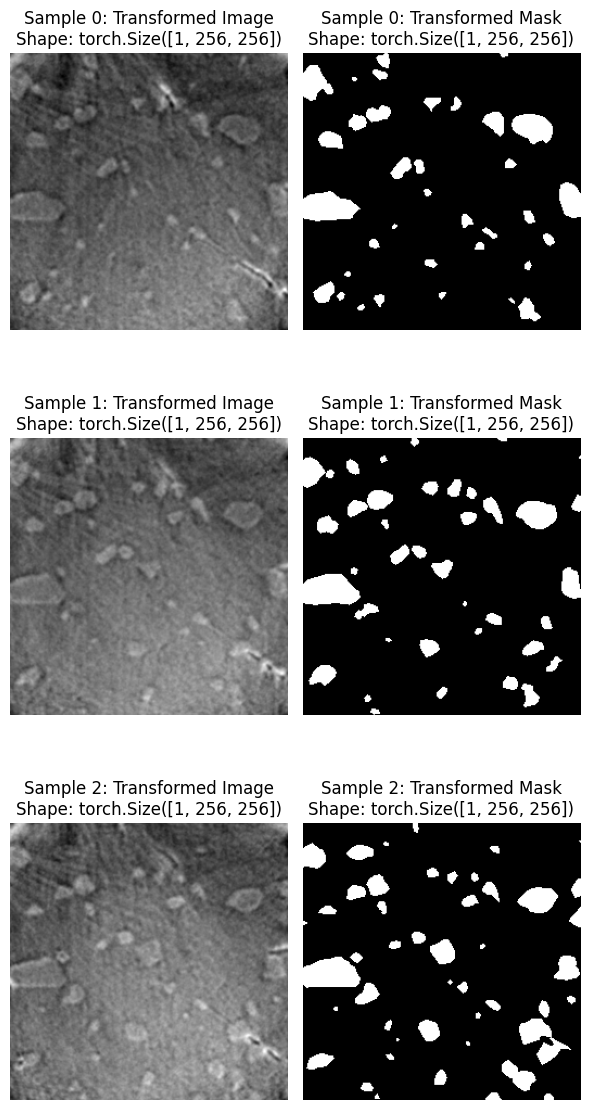


--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---
Analyzing Sample 0 (after transforms):
Total Pixels: 65536
Pore (1.0) Pixels:   6211 (9.48%)
Background (0.0) Pixels: 59325 (90.52%)


In [3]:
# 2. DATASET CLASS AND TRANSFORMS

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.mask_transform = mask_transform
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        # Load BOTH as-is (float images), do NOT use .convert()
        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

import numpy as np

# 1. NEW IMAGE TRANSFORM

# This transform will resize, then perform min-max normalization
# to stretch the contrast, just like your example code.

def normalize_image_transform(img):
    """Normalizes a float PIL image to a [0, 1] tensor."""
    # Convert PIL image to numpy array
    np_img = np.array(img, dtype=np.float32)

    # Get min/max for normalization
    min_val = np.min(np_img)
    max_val = np.max(np_img)

    # Perform min-max normalization (contrast stretching)
    # Add 1e-6 to prevent division by zero if image is all one color
    if max_val - min_val > 1e-6:
        normalized_img = (np_img - min_val) / (max_val - min_val)
    else:
        # If image is solid, just set to 0
        normalized_img = np.zeros(np_img.shape, dtype=np.float32)

    # Add channel dimension and return as float tensor
    return torch.from_numpy(normalized_img).unsqueeze(0)


image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform),   # <--- use this, like AE
])


# 2. MASK TRANSFORM (Stays the same as before)

# This transform resizes, then converts the float data to a binary
# 0/1 mask based on a threshold (pixel > 0)

mask_transform = transforms.Compose([
    # Use NEAREST for resizing masks (preserves labels)
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img) <= 0).unsqueeze(0).float())
])

# 1. Create a temporary dataset instance to test the transforms
print("Visualizing samples from the Dataset (after transforms)...")
viz_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# 2. Plot the first 3 samples
n_samples_to_plot = 3
plt.figure(figsize=(6, n_samples_to_plot * 4))

for i in range(n_samples_to_plot):
    # Get the transformed image and mask tensors
    image_tensor, mask_tensor = viz_dataset[i]

    # Squeeze() removes the channel dimension [1, 256, 256] -> [256, 256]
    # .numpy() converts the tensor for plotting

    # a) Transformed Image
    plt.subplot(n_samples_to_plot, 2, i*2 + 1)
    plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Image\nShape: {image_tensor.shape}")
    plt.axis('off')

    # b) Transformed (Thresholded) Mask
    plt.subplot(n_samples_to_plot, 2, i*2 + 2)
    plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Mask\nShape: {mask_tensor.shape}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Pixel Count for a Single Mask
print("\n--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---")

# 1. Get a single sample (the first one) from the dataset
# This applies the mask_transform, so the mask is already 0s and 1s
image_tensor, mask_tensor = viz_dataset[0]

# 2. Count the pixels
#    .sum() adds up all the 1.0s
pore_pixels = mask_tensor.sum().item()

#    .numel() gets the total number of elements
total_pixels = mask_tensor.numel()

#    The rest must be 0.0s
background_pixels = total_pixels - pore_pixels

# 3. Print the results
pore_percentage = (pore_pixels / total_pixels) * 100
bg_percentage = (background_pixels / total_pixels) * 100

print(f"Analyzing Sample 0 (after transforms):")
print(f"Total Pixels: {int(total_pixels)}")
print(f"Pore (1.0) Pixels:   {int(pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Background (0.0) Pixels: {int(background_pixels)} ({bg_percentage:.2f}%)")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import glob
import zipfile

# 1. UNZIP AND LOAD FILE PATHS
zip_path = "/content/segmentation_data.zip"
extract_path = "/content"

images_path = "/content/segmentation_data/Original Images"
masks_path  = "/content/segmentation_data/Original Masks"

# Ensure the extraction directory exists
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Only extract if the target images directory does not exist
if not os.path.exists(images_path):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print(f"Extracting {zip_path} to {extract_path}...")
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print(f"Directory {images_path} already exists. Skipping extraction.")

# Debugging step: List contents of the target directories after extraction
print(f"Contents of {images_path}: {os.listdir(images_path) if os.path.exists(images_path) else 'Directory not found'}")
print(f"Contents of {masks_path}: {os.listdir(masks_path) if os.path.exists(masks_path) else 'Directory not found'}")

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Directory /content/segmentation_data/Original Images already exists. Skipping extraction.
Contents of /content/segmentation_data/Original Images: ['image_v2_03.tif', 'image_v2_17.tif', 'image_v2_13.tif', 'image_v2_01.tif', 'image_v2_09.tif', 'image_v2_06.tif', 'image_v2_16.tif', 'image_v2_08.tif', 'image_v2_15.tif', 'image_v2_11.tif', 'image_v2_21.tif', 'image_v2_10.tif', 'image_v2_02.tif', 'image_v2_18.tif', 'image_v2_00.tif', 'image_v2_14.tif', 'image_v2_05.tif', 'image_v2_20.tif', 'image_v2_07.tif', 'image_v2_04.tif', 'image_v2_12.tif', 'image_v2_19.tif']
Contents of /content/segmentation_data/Original Masks: ['image_v2_mask_02.tif', 'image_v2_mask_12.tif', 'image_v2_mask_14.tif', 'image_v2_mask_03.tif', 'image_v2_mask_16.tif', 'image_v2_mask_21.tif', 'image_v2_mask_05.tif', 'image_v2_mask_17.tif', 'image_v2_mask_18.tif', 'image_v2_mask_06.tif', 'image_v2_mask_10.tif', 'image_v2_mask_19.tif', 'image_v2_mask_09.tif', 'image_v2_mask_20.tif', 'image_v2_mask_08.tif', 'image_v2_mask_04.t

In [4]:
# 3. DATASET SPLITTING AND DATALOADERS
full_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# Split
torch.manual_seed(42) # for reproducible splits
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created.")

Total samples: 22
Training samples: 17
Validation samples: 2
Test samples: 3

DataLoaders created.


INPUT stats -> min: 4.5226064685266465e-05 max: 0.0004311995580792427 mean: 0.00019753779633902013 std: 4.0973427530843765e-05


In [5]:
# 4. SANITY CHECK
try:
    images, masks = next(iter(train_loader))
    print(f"Images batch shape: {images.shape}")  # Should be [B, 1, 256, 256]
    print(f"Masks batch shape:  {masks.shape}")   # Should be [B, 1, 256, 256]
    print(f"Mask tensor data type: {masks.dtype}")
    print(f"Mask min value: {masks.min()}")
    print(f"Mask max value: {masks.max()}")
    print(f"Unique mask values in batch: {torch.unique(masks)}")
except (StopIteration, NameError):
    print("ERROR: Could not fetch a batch from train_loader. Check data paths/splitting.")

Images batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape:  torch.Size([8, 1, 256, 256])
Mask tensor data type: torch.float32
Mask min value: 0.0
Mask max value: 1.0
Unique mask values in batch: tensor([0., 1.])


In [6]:
# 5. LOSS FUNCTIONS

class BCELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        loss = torch.mean(y_pred - y_true*y_pred + torch.log(1 + torch.exp(-y_pred)))
        return loss

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        p = torch.sigmoid(y_pred)
        if p.dim() == 3:
            p = p.unsqueeze(1)
            y_true = y_true.unsqueeze(1)
        elif y_true.dim() == 3:
            y_true = y_true.unsqueeze(1)
        N = p.shape[0]
        p_f = p.contiguous().view(N, -1)
        y_f = y_true.contiguous().view(N, -1)
        smooth = 1.0
        intersection = (p_f * y_f).sum(dim=1)
        denom = p_f.sum(dim=1) + y_f.sum(dim=1)
        dice = (2.0 * intersection + smooth) / (denom + smooth)
        return (1.0 - dice).mean()

class FocalLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        bce = nn.functional.binary_cross_entropy_with_logits(y_pred, y_true, reduction="none")
        p = torch.sigmoid(y_pred)
        pt = p * y_true + (1 - p) * (1 - y_true)
        gamma = 2.0
        focal = torch.pow((1 - pt).clamp(min=1e-6), gamma)
        loss = focal * bce
        return loss.mean()

class BCELoss_TotalVariation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        loss = torch.mean(y_pred - y_true*y_pred + torch.log(1 + torch.exp(-y_pred)))
        x = torch.sigmoid(y_pred)
        if x.dim() == 3:
            x = x.unsqueeze(1)
        dh = x[:, :, 1:, :] - x[:, :, :-1, :]
        dw = x[:, :, :, 1:] - x[:, :, :, :-1]
        regularization = dh.abs().mean() + dw.abs().mean()
        return loss + 0.1*regularization

In [7]:
# 6. UNET MODEL

class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    # Default in_channels=1 is correct for our 1-channel grayscale image
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)
        out = self.output_conv(d1)
        return out

# **VARIATIONAL AUTOENCODER**

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class DeconvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_c, out_c)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x

class ImprovedVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # ---- Encoder: 3 downsamplings -> 32x32 ----
        self.enc1 = ConvBlock(1, 32)          # 256x256
        self.pool1 = nn.MaxPool2d(2)          # 128x128

        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)          # 64x64

        self.enc3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)          # 32x32

        # bottleneck feature map: 128 x 32 x 32
        self.flatten = nn.Flatten()
        flat_dim = 128 * 32 * 32

        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)

        # ---- Decoder ----
        self.fc_dec = nn.Linear(latent_dim, flat_dim)

        self.dec3 = ConvBlock(128, 128)   # keep 32x32
        self.up2  = DeconvBlock(128, 64)  # 32 -> 64
        self.up1  = DeconvBlock(64, 32)   # 64 -> 128
        self.up0  = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 128 -> 256
        self.out_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)

        # final activation for [0,1] images
        self.out_act = nn.Sigmoid()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.enc1(x)
        x = self.pool1(x)
        x = self.enc2(x)
        x = self.pool2(x)
        x = self.enc3(x)
        x = self.pool3(x)

        h = self.flatten(x)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        h = self.fc_dec(z)
        x = h.view(-1, 128, 32, 32)

        x = self.dec3(x)
        x = self.up2(x)
        x = self.up1(x)
        x = self.up0(x)
        x = self.out_conv(x)
        x = self.out_act(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar



In [21]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- VAE LOSS FUNCTION ---------
def vae_loss(x, x_hat, mu, logvar, beta=0.01):
  #beta = 0.01 This reduces regularisation even more → closer to AE behaviour,
  #slightly sharper reconstructions, but the latent space becomes less nicely Gaussian.
  #also tried w/ 1.0, 0.1
    """
    VAE loss:
      - recon_loss: per-pixel MSE (like your AE)
      - kl_loss: KL divergence, normalized per pixel
      - beta: weight of the KL term
    Returns: total_loss, recon_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_hat, x, reduction='mean')

    # KL divergence (sum over batch & latent dim)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Normalize KL to per-pixel scale (B * H * W, assuming 1 channel)
    n_pixels = x.size(0) * x.size(2) * x.size(3)
    kl = kl / n_pixels

    # Total loss
    loss = recon_loss + beta * kl

    return loss, recon_loss, kl

#MODEL + OPTIMIZER
latent_dim = 512 ## get some extra detail, but it’s diminishing returns
model = ImprovedVAE(latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 80
train_loss_history = []
val_loss_history = []

print("Starting VAE Training...")

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    #TRAINING
    for images, masks in train_loader:
        images = images.to(device).float()

        optimizer.zero_grad()
        x_hat, mu, logvar = model(images)

        loss, recon_loss, kl_loss = vae_loss(images, x_hat, mu, logvar, beta=0.01)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    avg_train_loss = np.mean(batch_losses)
    train_loss_history.append(avg_train_loss)

    #VALIDATION
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device).float()
            x_hat, mu, logvar = model(images)
            val_loss, _, _ = vae_loss(images, x_hat, mu, logvar, beta=0.01)
            val_batch_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_batch_losses)
    val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}"
        )

print("VAE Training Complete.")




Starting VAE Training...
Epoch [5/80] | Train Loss: 0.02865 | Val Loss: 0.02870
Epoch [10/80] | Train Loss: 0.02534 | Val Loss: 0.02713
Epoch [15/80] | Train Loss: 0.01556 | Val Loss: 0.01355
Epoch [20/80] | Train Loss: 0.01650 | Val Loss: 0.00820
Epoch [25/80] | Train Loss: 0.01592 | Val Loss: 0.00830
Epoch [30/80] | Train Loss: 0.01253 | Val Loss: 0.00755
Epoch [35/80] | Train Loss: 0.01026 | Val Loss: 0.00816
Epoch [40/80] | Train Loss: 0.01125 | Val Loss: 0.00816
Epoch [45/80] | Train Loss: 0.01025 | Val Loss: 0.00683
Epoch [50/80] | Train Loss: 0.00947 | Val Loss: 0.00836
Epoch [55/80] | Train Loss: 0.00963 | Val Loss: 0.00629
Epoch [60/80] | Train Loss: 0.00860 | Val Loss: 0.00607
Epoch [65/80] | Train Loss: 0.00725 | Val Loss: 0.00551
Epoch [70/80] | Train Loss: 0.00643 | Val Loss: 0.00567
Epoch [75/80] | Train Loss: 0.00579 | Val Loss: 0.00546
Epoch [80/80] | Train Loss: 0.00590 | Val Loss: 0.00506
VAE Training Complete.
VAE Training Complete.


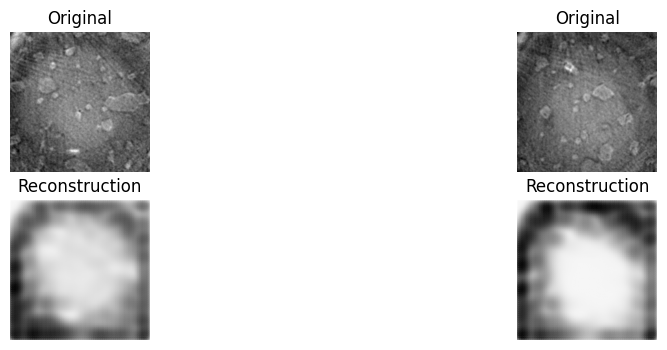

In [22]:
model.eval()

with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = images.to(device)
    x_hat, _, _ = model(images)

# Convert to numpy
images = images.cpu().numpy()
x_hat = x_hat.cpu().numpy()

batch_size = images.shape[0]
n_show = min(batch_size, 4)   # show max 4 samples

plt.figure(figsize=(12, 4))

for i in range(n_show):
    # Original
    plt.subplot(2, n_show, i + 1)
    plt.imshow(images[i, 0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstruction
    plt.subplot(2, n_show, i + 1 + n_show)
    plt.imshow(x_hat[i, 0], cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')

plt.show()



In [11]:
images, _ = next(iter(val_loader))
images = images.to(device).float()
x_hat, mu, logvar = model(images)

print("INPUT  stats  -> min:", images.min().item(),
      "max:", images.max().item(),
      "mean:", images.mean().item(),
      "std:", images.std().item())

print("X_HAT stats  -> min:", x_hat.min().item(),
      "max:", x_hat.max().item(),
      "mean:", x_hat.mean().item(),
      "std:", x_hat.std().item())


INPUT  stats  -> min: 0.0 max: 1.0 mean: 0.39389699697494507 std: 0.11426889151334763
X_HAT stats  -> min: 0.162260040640831 max: 0.5139118432998657 mean: 0.3998810052871704 std: 0.07976548373699188


# **Autoencoder**

In [16]:
import torch
import torch.nn as nn

class TomographyAutoEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(TomographyAutoEncoder, self).__init__()

        # ENCODER
        # Input: (Batch, 1, 256, 256)
        self.encoder_conv = nn.Sequential(
            # Layer 1: 256x256 -> 128x128
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Layer 2: 128x128 -> 64x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # Layer 3: 64x64 -> 32x32
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # Layer 4: 32x32 -> 16x16
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Flatten size: 256 channels * 16 * 16 = 65,536
        self.flatten_dim = 256 * 16 * 16

        # Latent Bottleneck
        self.fc_encoder = nn.Linear(self.flatten_dim, latent_dim)

        # DECODER
        self.fc_decoder = nn.Linear(latent_dim, self.flatten_dim)

        self.decoder_conv = nn.Sequential(
            # Unflatten to (256, 16, 16) happens in forward

            # Layer 4: 16x16 -> 32x32
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # Layer 3: 32x32 -> 64x64
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            # Layer 2: 64x64 -> 128x128
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            # Layer 1: 128x128 -> 256x256
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # Output must be between 0 and 1
        )

    def forward(self, x):
        # 1. Encode
        out = self.encoder_conv(x)
        out = out.view(out.size(0), -1) # Flatten
        z = self.fc_encoder(out)  # Latent space

        # 2. Decode
        out = self.fc_decoder(z)
        out = out.view(out.size(0), 256, 16, 16) # Unflatten
        x_hat = self.decoder_conv(out)

        return {'z': z, 'x_hat': x_hat}

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# latent_dim=128 is a good balance for complex texture images
AE = TomographyAutoEncoder(latent_dim=128).to(device)

print(AE)

TomographyAutoEncoder(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (fc_encoder): Linear(in_features=65536, out_features=128, bias=True)
  (fc_decoder): Linear(in_features=128, out_features=6

In [17]:
# Configuration
optimizer = optim.Adam(AE.parameters(), lr=1e-3)

# MSE Loss is usually better for reconstruction of textures/grayscale than BCE
loss_function = nn.MSELoss()

num_epochs = 80
train_loss_history = []
val_loss_history = []

print("Starting Autoencoder Training...")

for epoch in range(num_epochs):
    AE.train()
    batch_loss = []

    # 1. Training Phase
    for batch_idx, (images, masks) in enumerate(train_loader):
        # Move images to GPU
        images = images.to(device)

        # Forward pass
        outputs = AE(images)
        x_hat = outputs['x_hat']

        # Calculate Loss: Compare Reconstruction (x_hat) to Original (images)
        loss = loss_function(x_hat, images)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())

    avg_train_loss = np.mean(batch_loss)
    train_loss_history.append(avg_train_loss)

    # 2. Validation Phase
    AE.eval()
    val_batch_loss = []
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            outputs = AE(images)
            x_hat = outputs['x_hat']
            loss = loss_function(x_hat, images)
            val_batch_loss.append(loss.item())

    avg_val_loss = np.mean(val_batch_loss)
    val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

print("Training Complete.")

Starting Autoencoder Training...
Epoch [5/80] | Train Loss: 0.00891 | Val Loss: 0.01391
Epoch [10/80] | Train Loss: 0.00678 | Val Loss: 0.00651
Epoch [15/80] | Train Loss: 0.00638 | Val Loss: 0.00483
Epoch [20/80] | Train Loss: 0.00891 | Val Loss: 0.00468
Epoch [25/80] | Train Loss: 0.00432 | Val Loss: 0.00478
Epoch [30/80] | Train Loss: 0.00447 | Val Loss: 0.00412
Epoch [35/80] | Train Loss: 0.00527 | Val Loss: 0.00428
Epoch [40/80] | Train Loss: 0.00528 | Val Loss: 0.00396
Epoch [45/80] | Train Loss: 0.00376 | Val Loss: 0.00432
Epoch [50/80] | Train Loss: 0.00344 | Val Loss: 0.00372
Epoch [55/80] | Train Loss: 0.00291 | Val Loss: 0.00347
Epoch [60/80] | Train Loss: 0.00295 | Val Loss: 0.00360
Epoch [65/80] | Train Loss: 0.00248 | Val Loss: 0.00340
Epoch [70/80] | Train Loss: 0.00380 | Val Loss: 0.00338
Epoch [75/80] | Train Loss: 0.00281 | Val Loss: 0.00330
Epoch [80/80] | Train Loss: 0.00247 | Val Loss: 0.00330
Training Complete.


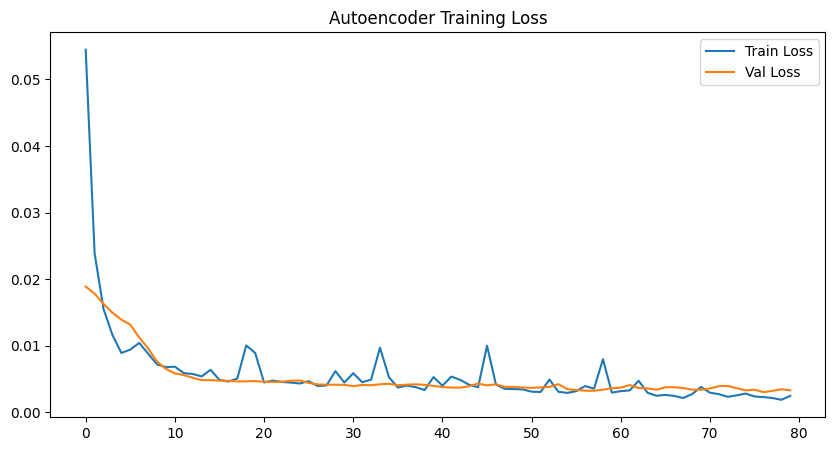


Visualizing 2 reconstructions


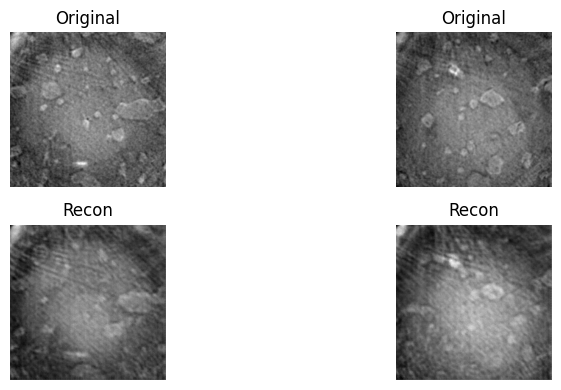

In [18]:
# Plot Training Curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Autoencoder Training Loss")
plt.legend()
plt.show()

# Visualize Reconstructions
AE.eval()
with torch.no_grad():
    # Get a batch from validation set
    images, _ = next(iter(val_loader))
    images = images.to(device)

    # Reconstruct
    outputs = AE(images)
    x_hat = outputs['x_hat']

    # Move to CPU for plotting
    images = images.cpu()
    x_hat = x_hat.cpu()

# FIX: Dynamically determine n_samples based on the actual batch size
batch_current_size = images.size(0)
n_samples = min(5, batch_current_size)

print(f"\nVisualizing {n_samples} reconstructions")

plt.figure(figsize=(10, 4))
for i in range(n_samples):
    # Original
    ax = plt.subplot(2, n_samples, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstruction
    ax = plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(x_hat[i].squeeze(), cmap='gray')
    plt.title("Recon")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Segmentation 2: Latent Space**

In [19]:
class LatentSegmentationModel(nn.Module):
    def __init__(self, latent_dim=128):
        super(LatentSegmentationModel, self).__init__()

        # This matches the flatten_dim from your Autoencoder
        # 256 channels * 16 * 16 spatial size
        self.flatten_dim = 256 * 16 * 16

        # 1. Expand z back to the flattened feature map size
        self.fc_decoder = nn.Linear(latent_dim, self.flatten_dim)

        # 2. Convolutional Upsampling (Decoder)
        # We reuse the exact same architecture as the AE Decoder
        self.decoder_conv = nn.Sequential(
            # Layer 4: 16x16 -> 32x32
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True), # ReLU is standard for mask generation layers

            # Layer 3: 32x32 -> 64x64
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Layer 2: 64x64 -> 128x128
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Layer 1: 128x128 -> 256x256
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            # No Sigmoid here if using BCEWithLogits, but for consistency with DiceLoss/UNet logic:
            # We will return logits and handle activation in loss or valid
        )

    def forward(self, z):
        # Linear expansion
        out = self.fc_decoder(z)

        # Reshape to (Batch, 256, 16, 16)
        out = out.view(out.size(0), 256, 16, 16)

        # Upsample
        mask_logits = self.decoder_conv(out)
        return mask_logits

# Initialize
latent_model = LatentSegmentationModel(latent_dim=128).to(device)
print(latent_model)

LatentSegmentationModel(
  (fc_decoder): Linear(in_features=128, out_features=65536, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)


Starting training on Latent Space (z)...
* Epoch 01/20 (Time: 0.34s)
  - Train Loss: 0.8099
  - Val Loss:   0.8104
* Epoch 02/20 (Time: 0.20s)
  - Train Loss: 0.7770
  - Val Loss:   0.7959
* Epoch 03/20 (Time: 0.21s)
  - Train Loss: 0.7254
  - Val Loss:   0.7694
* Epoch 04/20 (Time: 0.19s)
  - Train Loss: 0.6816
  - Val Loss:   0.7307
* Epoch 05/20 (Time: 0.20s)
  - Train Loss: 0.6638
  - Val Loss:   0.6877
* Epoch 06/20 (Time: 0.20s)
  - Train Loss: 0.6174
  - Val Loss:   0.6517
* Epoch 07/20 (Time: 0.20s)
  - Train Loss: 0.5972
  - Val Loss:   0.6313
* Epoch 08/20 (Time: 0.20s)
  - Train Loss: 0.5863
  - Val Loss:   0.6160
* Epoch 09/20 (Time: 0.20s)
  - Train Loss: 0.5660
  - Val Loss:   0.6015
* Epoch 10/20 (Time: 0.19s)
  - Train Loss: 0.5391
  - Val Loss:   0.5965
* Epoch 11/20 (Time: 0.19s)
  - Train Loss: 0.5174
  - Val Loss:   0.5907
* Epoch 12/20 (Time: 0.20s)
  - Train Loss: 0.5072
  - Val Loss:   0.5872
* Epoch 13/20 (Time: 0.21s)
  - Train Loss: 0.4888
  - Val Loss:   0.57

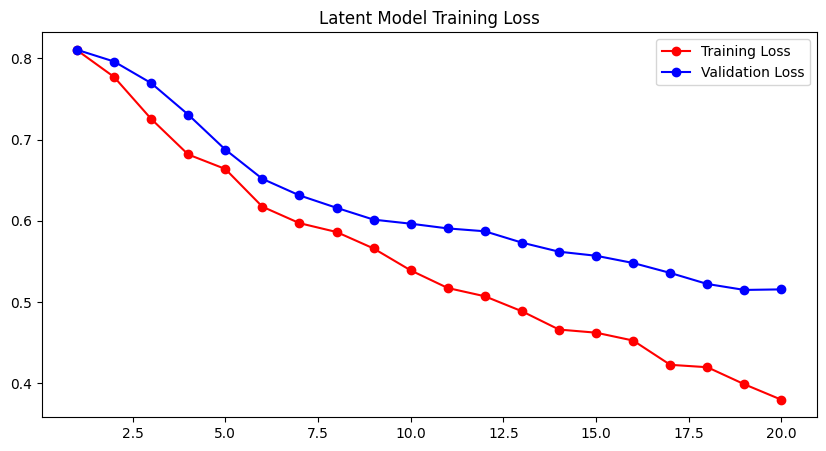

In [20]:
# Configuration
optimizer = optim.Adam(latent_model.parameters(), lr=1e-3)
loss_fn = DiceLoss()

epochs = 20
train_losses = []
val_losses = []

print("Starting training on Latent Space (z)...")

# Ensure AE is in eval mode and frozen
AE.eval()

for epoch in range(epochs):
    tic = time()

    # Training Phase
    latent_model.train()
    avg_loss = 0

    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # 1. EXTRACT Z (Using Frozen Autoencoder)
        with torch.no_grad():
            # We need to manually replicate the encoder steps if we didn't save a separate encoder
            # But since we have AE class, we can just call AE forward and take 'z'
            outputs = AE(X_batch)
            z = outputs['z']

        # 2. PREDICT MASK (Using z)
        optimizer.zero_grad()
        y_pred_logits = latent_model(z)

        # 3. CALCULATE LOSS
        loss = loss_fn(y_pred_logits, y_true)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)

    # Validation Phase
    latent_model.eval()
    avg_val_loss = 0

    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)

            # Get z
            outputs = AE(X_batch)
            z = outputs['z']

            # Predict
            y_pred_logits = latent_model(z)
            val_loss = loss_fn(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader)

    toc = time()
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    print(f'* Epoch {epoch+1:02d}/{epochs} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Val Loss:   {avg_val_loss:.4f}')

# Plot Loss
epoch_count = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_losses, 'r-o', label='Training Loss')
plt.plot(epoch_count, val_losses, 'b-o', label='Validation Loss')
plt.title('Latent Model Training Loss')
plt.legend()
plt.show()


Starting evaluation of Latent Model on the test set...
Test Set Results (Averaged over 1 batches)
Pixel Accuracy (Rand): 89.74%
Dice Coefficient:      0.5947
Jaccard Index (IoU):   0.4232
Precision:             0.5091
Recall (Sensitivity):  0.7149

Visualizing some test predictions...


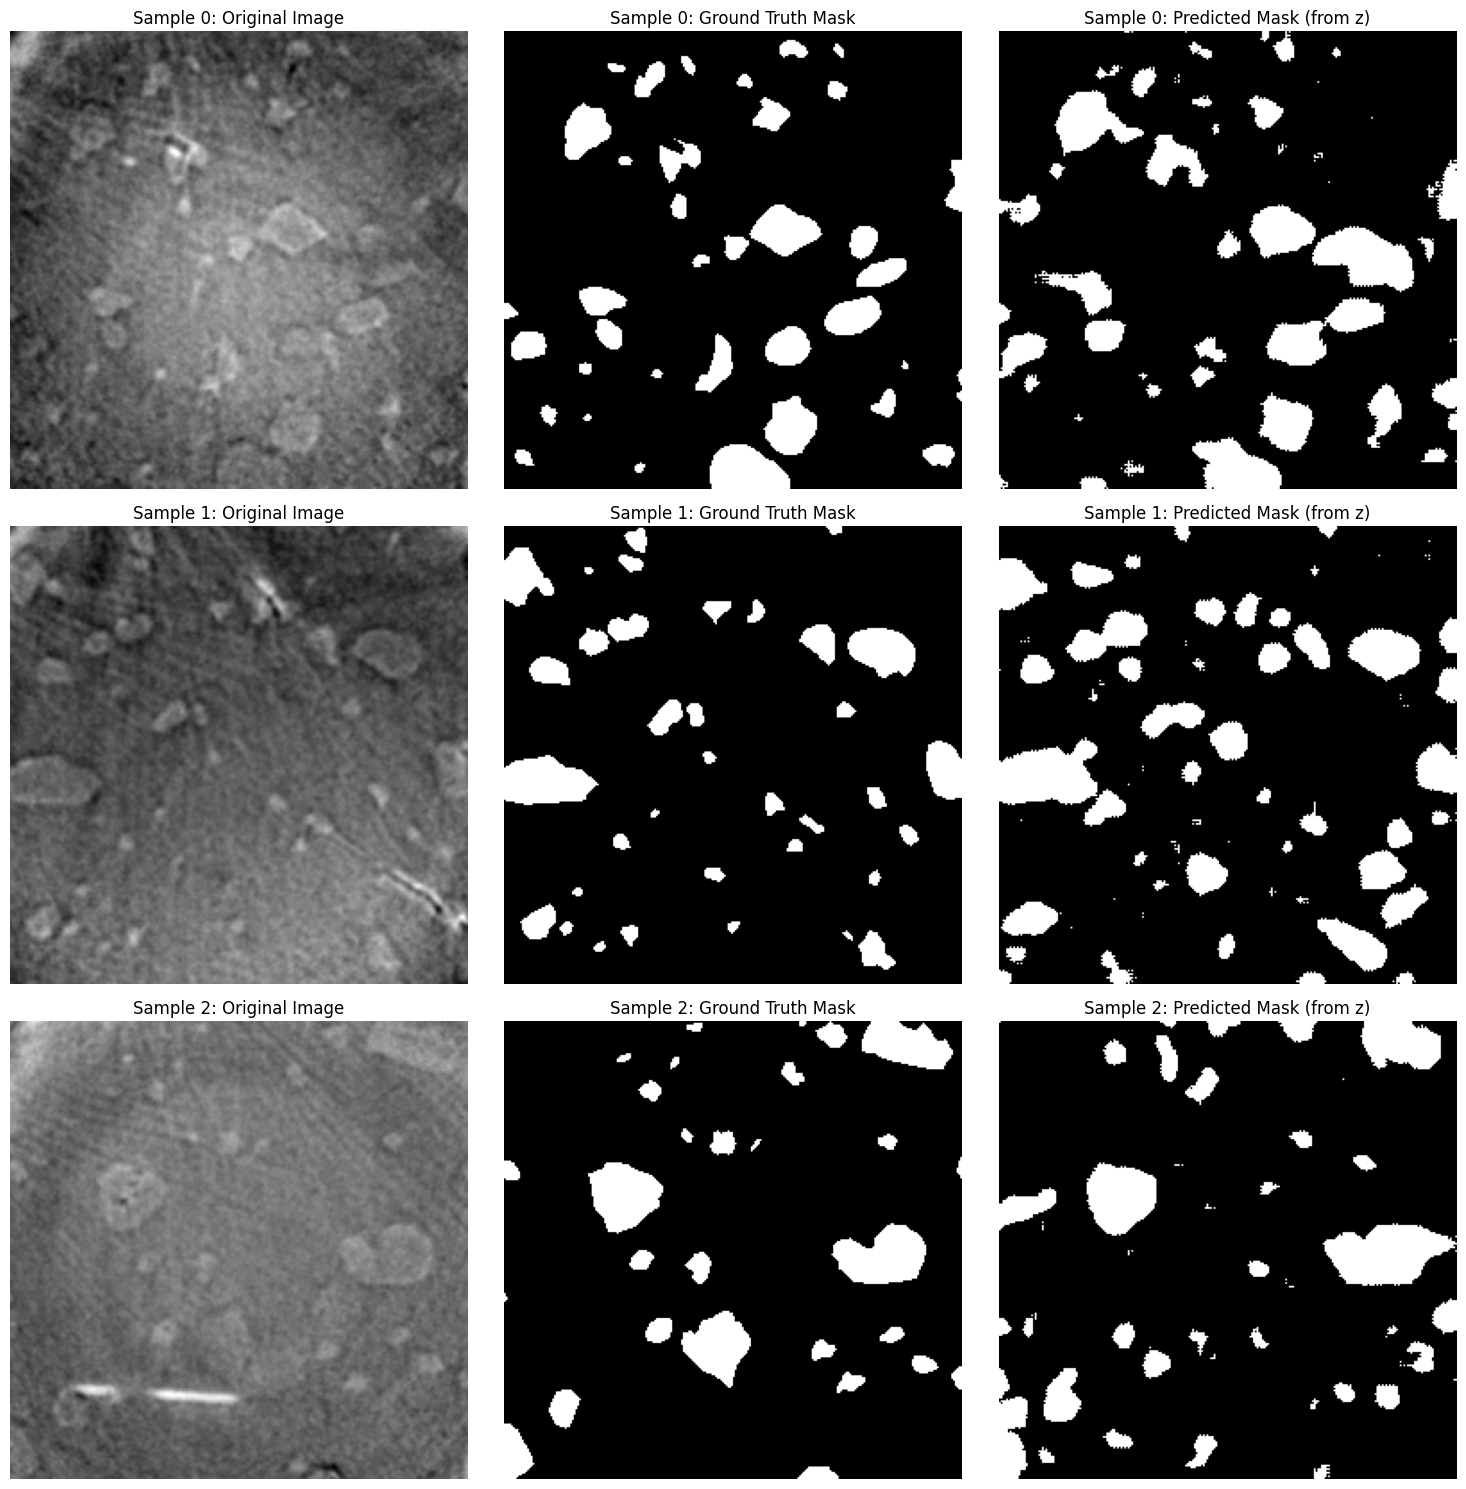

In [21]:
# 1. SETUP FOR EVALUATION
latent_model.eval()
AE.eval()

# 2. METRIC FUNCTION (Unchanged)
def calculate_all_metrics_batch(preds, y_true, smooth=1e-6):
    """
    Calculates all 5 metrics for a batch.
    Metrics are computed pixel-wise for the entire batch.
    """
    # Flatten tensors
    preds_f = preds.contiguous().view(-1).float()
    y_f = y_true.contiguous().view(-1).float()

    # Core Components
    tp = (preds_f * y_f).sum()
    fp = (preds_f * (1 - y_f)).sum()
    fn = ((1 - preds_f) * y_f).sum()
    tn = ((1 - preds_f) * (1 - y_f)).sum()
    total_pixels = y_f.numel()

    # Calculate Metrics
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    accuracy = (tp + tn) / total_pixels
    dice = (2.0 * tp + smooth) / (tp + fp + tp + fn + smooth)
    jaccard = (tp + smooth) / (tp + fp + fn + smooth)

    return precision.item(), recall.item(), accuracy.item(), dice.item(), jaccard.item()


# 3. TEST SET EVALUATION LOOP
print("\nStarting evaluation of Latent Model on the test set...")

# Initialize accumulators for all metrics
total_precision = 0
total_recall = 0
total_accuracy = 0
total_dice = 0
total_jaccard = 0
total_pore_pixels = 0
total_bg_pixels = 0

# Disable gradient calculations
with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # KEY CHANGE: Extract Z first
        outputs = AE(X_batch)
        z = outputs['z']

        # 1. Forward pass (Input is Z)
        y_pred_logits = latent_model(z)

        # 2. Convert logits to binary predictions
        y_pred_probs = torch.sigmoid(y_pred_logits)
        y_pred_binary = (y_pred_probs > 0.5).float() # Threshold at 0.5

        # 3. Calculate all metrics for this batch and add to totals
        p, r, acc, d, j = calculate_all_metrics_batch(y_pred_binary, y_true)

        total_precision += p
        total_recall    += r
        total_accuracy  += acc
        total_dice      += d
        total_jaccard   += j

        # 4. Calculate pixel counts from the ground truth masks
        batch_pores = y_true.sum().item()
        batch_total = y_true.numel()
        batch_bg = batch_total - batch_pores

        total_pore_pixels += batch_pores
        total_bg_pixels += batch_bg

# CALCULATE AND PRINT FINAL METRICS
num_batches = len(test_loader)
avg_precision = total_precision / num_batches
avg_recall    = total_recall / num_batches
avg_accuracy  = total_accuracy / num_batches
avg_dice      = total_dice / num_batches
avg_jaccard   = total_jaccard / num_batches

print(f"Test Set Results (Averaged over {num_batches} batches)")
print(f"Pixel Accuracy (Rand): {avg_accuracy * 100:.2f}%")
print(f"Dice Coefficient:      {avg_dice:.4f}")
print(f"Jaccard Index (IoU):   {avg_jaccard:.4f}")
print(f"Precision:             {avg_precision:.4f}")
print(f"Recall (Sensitivity):  {avg_recall:.4f}")

# VISUALIZE A FEW PREDICTIONS
print("\nVisualizing some test predictions...")

# Get one batch from the test loader
X_test_viz, y_test_viz = next(iter(test_loader))
X_test_viz = X_test_viz.to(device)

latent_model.eval()
AE.eval()

with torch.no_grad():
    # Transform X -> Z -> Mask
    outputs = AE(X_test_viz)
    z = outputs['z']
    y_pred_logits_viz = latent_model(z)

    y_pred_probs_viz = torch.sigmoid(y_pred_logits_viz)
    y_pred_binary_viz = (y_pred_probs_viz > 0.5).float()

# Move data to CPU for plotting with numpy/matplotlib
X_test_cpu = X_test_viz.cpu()
y_test_cpu = y_test_viz.cpu()
y_pred_cpu = y_pred_binary_viz.cpu()

# Plot the first N samples (e.g., 3)
n_samples_to_plot = min(3, len(X_test_cpu)) # Ensure we don't exceed batch size

plt.figure(figsize=(15, n_samples_to_plot * 5))
for i in range(n_samples_to_plot):

    # a) Original Image (1-channel)
    plt.subplot(n_samples_to_plot, 3, i*3 + 1)
    plt.imshow(X_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Original Image")
    plt.axis('off')

    # b) Ground Truth Mask
    plt.subplot(n_samples_to_plot, 3, i*3 + 2)
    plt.imshow(y_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Ground Truth Mask")
    plt.axis('off')

    # c) Predicted Mask (From Latent Space)
    plt.subplot(n_samples_to_plot, 3, i*3 + 3)
    plt.imshow(y_pred_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Predicted Mask (from z)")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Segmentation 3. Reconstruction**

In [22]:
# Instantiate a NEW copy of the U-Net
# We call it 'model_recon' to distinguish it from the baseline
model_recon = UNet(in_channels=1, out_channels=1).to(device)

print("Initialized U-Net for Reconstruction-based Segmentation")

Initialized U-Net for Reconstruction-based Segmentation


Starting training on Reconstructions (x_hat)...
* Epoch 01/20 (Time: 1.22s)
  - Train Loss: 0.7808
  - Val Loss:   0.8134
* Epoch 02/20 (Time: 1.13s)
  - Train Loss: 0.7489
  - Val Loss:   0.8154
* Epoch 03/20 (Time: 1.13s)
  - Train Loss: 0.7331
  - Val Loss:   0.7975
* Epoch 04/20 (Time: 1.15s)
  - Train Loss: 0.7121
  - Val Loss:   0.7973
* Epoch 05/20 (Time: 1.14s)
  - Train Loss: 0.7030
  - Val Loss:   0.7973
* Epoch 06/20 (Time: 1.13s)
  - Train Loss: 0.7105
  - Val Loss:   0.7974
* Epoch 07/20 (Time: 1.13s)
  - Train Loss: 0.6814
  - Val Loss:   0.7970
* Epoch 08/20 (Time: 1.17s)
  - Train Loss: 0.6729
  - Val Loss:   0.7933
* Epoch 09/20 (Time: 1.66s)
  - Train Loss: 0.6695
  - Val Loss:   0.7899
* Epoch 10/20 (Time: 1.54s)
  - Train Loss: 0.6567
  - Val Loss:   0.7927
* Epoch 11/20 (Time: 1.13s)
  - Train Loss: 0.6436
  - Val Loss:   0.7699
* Epoch 12/20 (Time: 1.14s)
  - Train Loss: 0.6368
  - Val Loss:   0.8346
* Epoch 13/20 (Time: 1.14s)
  - Train Loss: 0.6152
  - Val Loss:

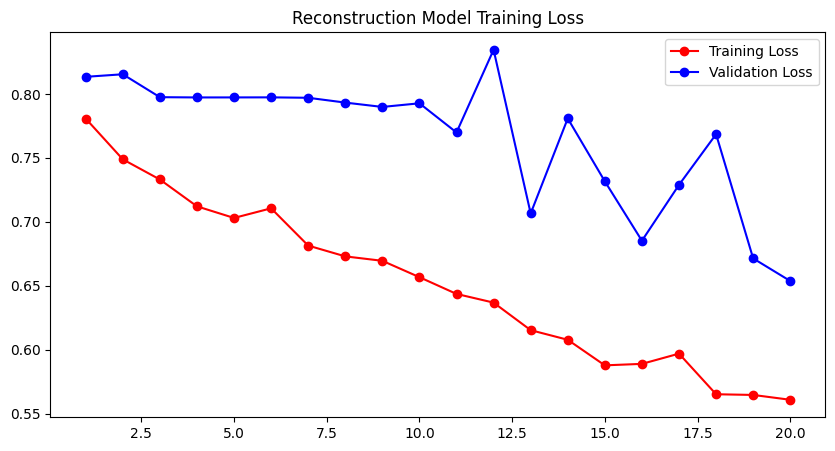

In [23]:
# Configuration
optimizer = optim.Adam(model_recon.parameters(), lr=1e-3)
loss_fn = DiceLoss()

epochs = 20
train_losses = []
val_losses = []

print("Starting training on Reconstructions (x_hat)...")

# Ensure AE is frozen
AE.eval()

for epoch in range(epochs):
    tic = time()

    # Training Phase
    model_recon.train()
    avg_loss = 0

    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # 1. GET RECONSTRUCTION (Using Frozen Autoencoder)
        with torch.no_grad():
            outputs = AE(X_batch)
            x_hat = outputs['x_hat']
            # Note: x_hat is essentially a denoised version of X_batch

        # 2. TRAIN U-NET ON x_hat
        optimizer.zero_grad()
        y_pred_logits = model_recon(x_hat)

        # 3. CALCULATE LOSS
        loss = loss_fn(y_pred_logits, y_true)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)

    # Validation Phase
    model_recon.eval()
    avg_val_loss = 0

    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)

            # Get x_hat
            outputs = AE(X_batch)
            x_hat = outputs['x_hat']

            # Predict
            y_pred_logits = model_recon(x_hat)
            val_loss = loss_fn(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader)

    toc = time()
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    print(f'* Epoch {epoch+1:02d}/{epochs} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Val Loss:   {avg_val_loss:.4f}')

# Plot Loss
epoch_count = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_losses, 'r-o', label='Training Loss')
plt.plot(epoch_count, val_losses, 'b-o', label='Validation Loss')
plt.title('Reconstruction Model Training Loss')
plt.legend()
plt.show()


Starting evaluation of Reconstruction Model on the test set...
Test Set Results (Averaged over 1 batches)
Dice Coefficient:      0.4559
Jaccard Index (IoU):   0.2953

Visualizing comparison...


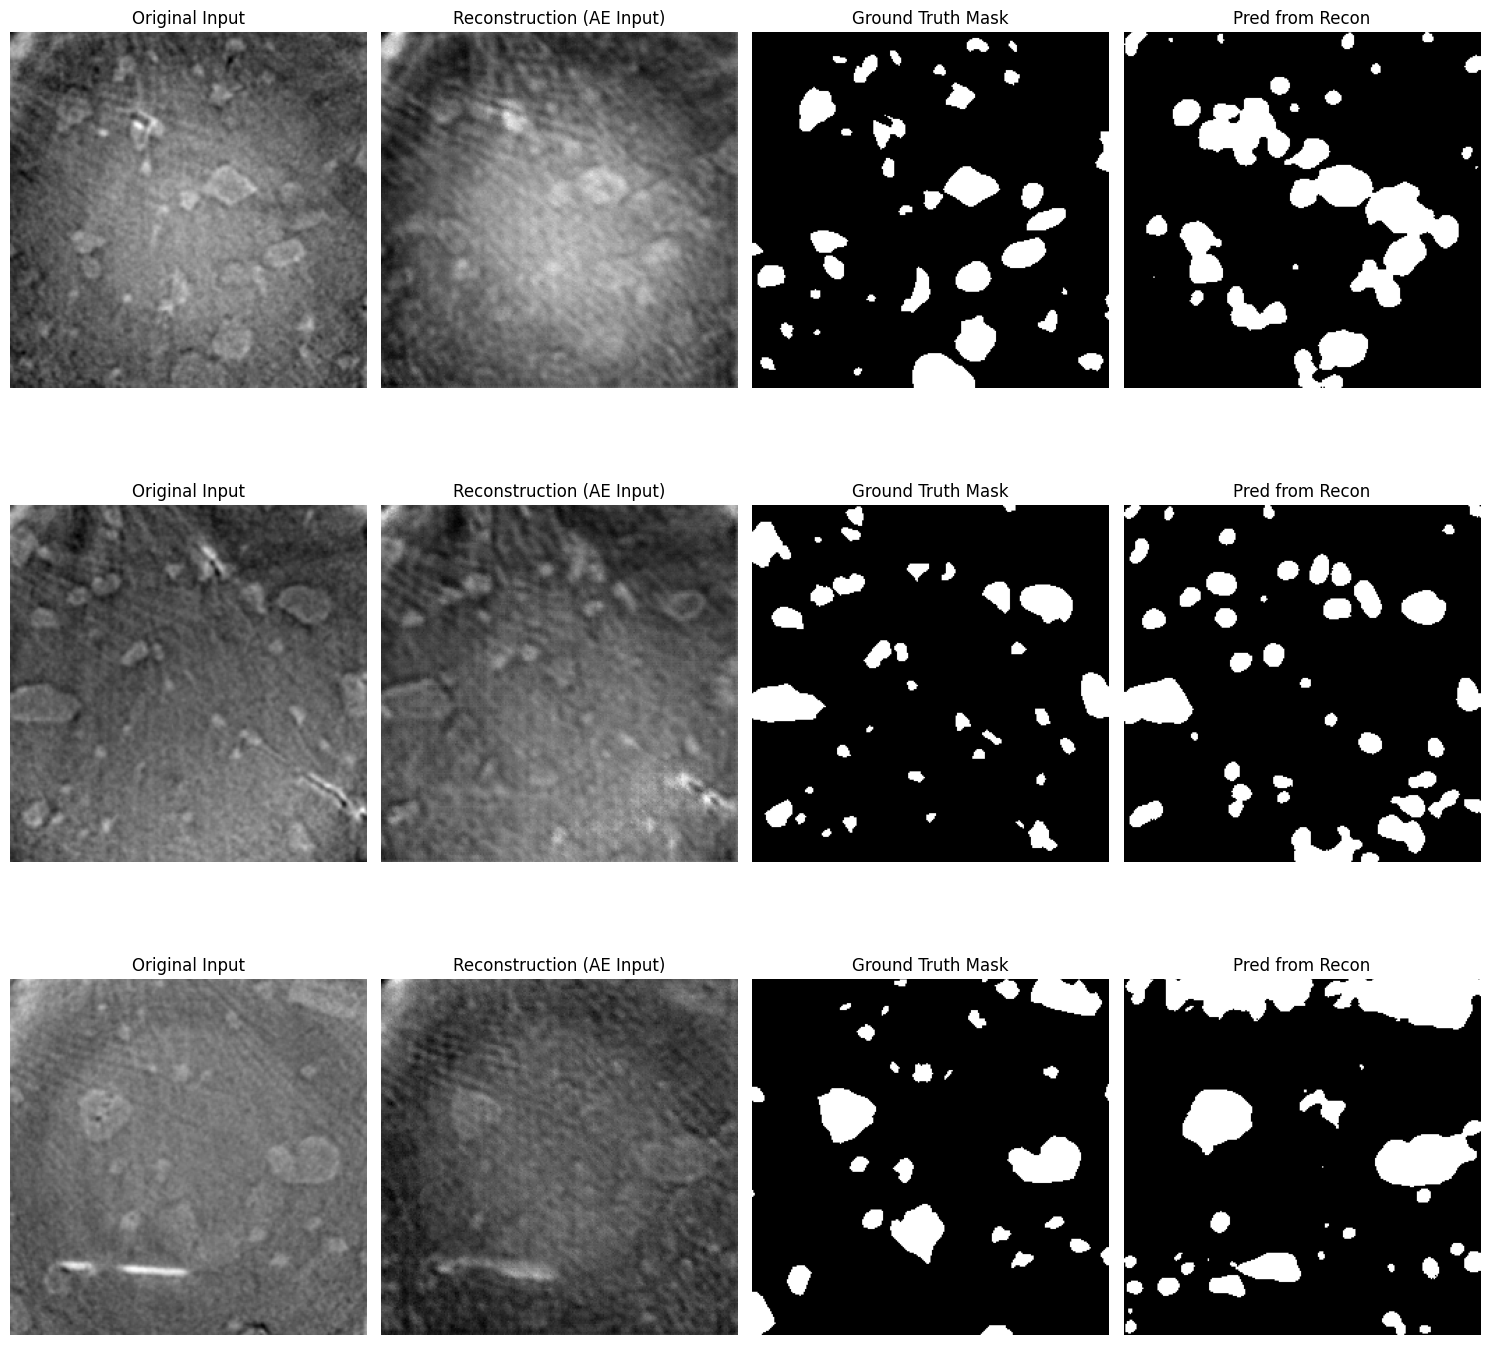

In [24]:
# 1. SETUP
model_recon.eval()
AE.eval()

# 2. METRIC FUNCTION (Already defined previously)

# 3. TEST SET EVALUATION LOOP
print("\nStarting evaluation of Reconstruction Model on the test set...")

total_precision = 0
total_recall = 0
total_accuracy = 0
total_dice = 0
total_jaccard = 0

with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # STEP 1: Get Reconstructio
        outputs = AE(X_batch)
        x_hat = outputs['x_hat']

        # STEP 2: Predict using Reconstruction
        y_pred_logits = model_recon(x_hat)

        # Post-process
        y_pred_probs = torch.sigmoid(y_pred_logits)
        y_pred_binary = (y_pred_probs > 0.5).float()

        # Metrics
        p, r, acc, d, j = calculate_all_metrics_batch(y_pred_binary, y_true)

        total_precision += p
        total_recall    += r
        total_accuracy  += acc
        total_dice      += d
        total_jaccard   += j

# PRINT FINAL METRICS
num_batches = len(test_loader)
avg_dice      = total_dice / num_batches
avg_jaccard   = total_jaccard / num_batches

print(f"Test Set Results (Averaged over {num_batches} batches)")
print(f"Dice Coefficient:      {avg_dice:.4f}")
print(f"Jaccard Index (IoU):   {avg_jaccard:.4f}")

# --- VISUALIZATION ---
print("\nVisualizing comparison...")

X_test_viz, y_test_viz = next(iter(test_loader))
X_test_viz = X_test_viz.to(device)

with torch.no_grad():
    # 1. Get Recon
    outputs = AE(X_test_viz)
    x_hat_viz = outputs['x_hat']

    # 2. Get Pred
    y_pred_logits_viz = model_recon(x_hat_viz)
    y_pred_binary_viz = (torch.sigmoid(y_pred_logits_viz) > 0.5).float()

# Move to CPU
X_cpu = X_test_viz.cpu()
X_hat_cpu = x_hat_viz.cpu()
y_true_cpu = y_test_viz.cpu()
y_pred_cpu = y_pred_binary_viz.cpu()

n_samples = min(3, len(X_cpu))

plt.figure(figsize=(15, 5*n_samples))
for i in range(n_samples):
    # Row i

    # 1. Original
    plt.subplot(n_samples, 4, i*4 + 1)
    plt.imshow(X_cpu[i].squeeze(), cmap='gray')
    plt.title("Original Input")
    plt.axis('off')

    # 2. Reconstruction (The input to the model)
    plt.subplot(n_samples, 4, i*4 + 2)
    plt.imshow(X_hat_cpu[i].squeeze(), cmap='gray')
    plt.title("Reconstruction (AE Input)")
    plt.axis('off')

    # 3. Ground Truth
    plt.subplot(n_samples, 4, i*4 + 3)
    plt.imshow(y_true_cpu[i].squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # 4. Prediction
    plt.subplot(n_samples, 4, i*4 + 4)
    plt.imshow(y_pred_cpu[i].squeeze(), cmap='gray')
    plt.title("Pred from Recon")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Segmentation 4. Combined Model**

In [25]:
class CombinedInputReconModel(nn.Module):
    def __init__(self, ae_model):
        super(CombinedInputReconModel, self).__init__()

        # 1. Frozen AE
        self.ae = ae_model
        for param in self.ae.parameters():
            param.requires_grad = False

        # 2. U-Net
        # Input channels: 1 (Raw) + 1 (Recon) = 2
        # We don't need special processors because dimensions match perfectly
        self.unet = UNet(in_channels=2, out_channels=1)

    def forward(self, x):
        # 1. Get Reconstruction (No Grad)
        with torch.no_grad():
            outputs = self.ae(x)
            x_hat = outputs['x_hat'] # [Batch, 1, 256, 256]

        # 2. Concatenate [Batch, 2, 256, 256]
        # Channel 0: Raw Image (Noisy, sharp)
        # Channel 1: Reconstruction (Clean, potentially blurry)
        combined_input = torch.cat([x, x_hat], dim=1)

        # 3. Predict
        mask_logits = self.unet(combined_input)
        return mask_logits

# Initialize
model_input_recon = CombinedInputReconModel(AE).to(device)
print("Initialized Combined Model (Input + Reconstruction). Input Channels: 2")

Initialized Combined Model (Input + Reconstruction). Input Channels: 2


Starting training on Input + Reconstruction...
* Epoch 01/20 (Time: 1.25s)
  - Train Loss: 0.7682
  - Val Loss:   0.8142
* Epoch 02/20 (Time: 1.14s)
  - Train Loss: 0.7007
  - Val Loss:   0.8155
* Epoch 03/20 (Time: 1.15s)
  - Train Loss: 0.6876
  - Val Loss:   0.8285
* Epoch 04/20 (Time: 1.15s)
  - Train Loss: 0.6654
  - Val Loss:   0.8217
* Epoch 05/20 (Time: 1.23s)
  - Train Loss: 0.6393
  - Val Loss:   0.8729
* Epoch 06/20 (Time: 1.23s)
  - Train Loss: 0.6266
  - Val Loss:   0.8060
* Epoch 07/20 (Time: 1.22s)
  - Train Loss: 0.5904
  - Val Loss:   0.8131
* Epoch 08/20 (Time: 1.17s)
  - Train Loss: 0.5806
  - Val Loss:   0.8203
* Epoch 09/20 (Time: 1.16s)
  - Train Loss: 0.5770
  - Val Loss:   0.8094
* Epoch 10/20 (Time: 1.16s)
  - Train Loss: 0.5552
  - Val Loss:   0.7889
* Epoch 11/20 (Time: 1.16s)
  - Train Loss: 0.5430
  - Val Loss:   0.7957
* Epoch 12/20 (Time: 1.16s)
  - Train Loss: 0.5447
  - Val Loss:   0.7385
* Epoch 13/20 (Time: 1.16s)
  - Train Loss: 0.5067
  - Val Loss: 

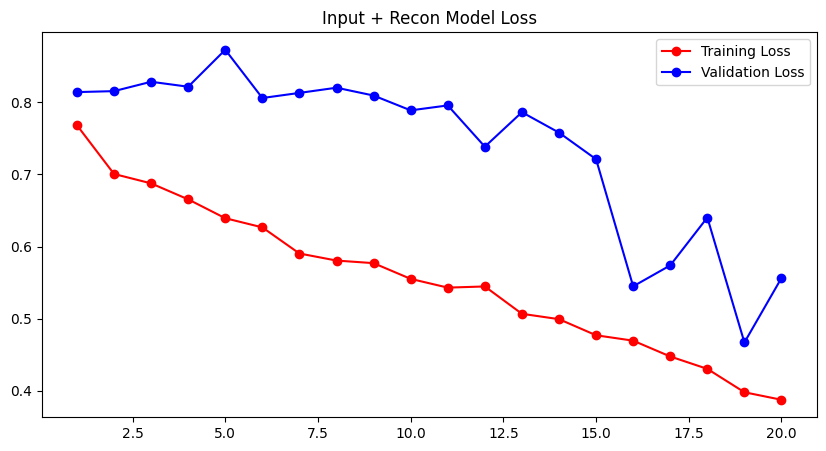

In [26]:
# Configuration
optimizer = optim.Adam(model_input_recon.parameters(), lr=1e-3)
loss_fn = DiceLoss()

epochs = 20
train_losses = []
val_losses = []

print("Starting training on Input + Reconstruction...")

for epoch in range(epochs):
    tic = time()

    # Training Phase
    model_input_recon.train()
    model_input_recon.ae.eval() # Ensure AE is frozen

    avg_loss = 0
    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        optimizer.zero_grad()

        # Forward pass handles the rest
        y_pred_logits = model_input_recon(X_batch)

        loss = loss_fn(y_pred_logits, y_true)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)

    # Validation Phase
    model_input_recon.eval()
    avg_val_loss = 0
    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)

            y_pred_logits = model_input_recon(X_batch)
            val_loss = loss_fn(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader)

    toc = time()
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    print(f'* Epoch {epoch+1:02d}/{epochs} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Val Loss:   {avg_val_loss:.4f}')

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, 'r-o', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, 'b-o', label='Validation Loss')
plt.title('Input + Recon Model Loss')
plt.legend()
plt.show()


Starting evaluation of Input+Recon Model...
Test Set Results (Input + Reconstruction)
Dice Coefficient:      0.4061
Jaccard Index (IoU):   0.2548

Visualizing Results...


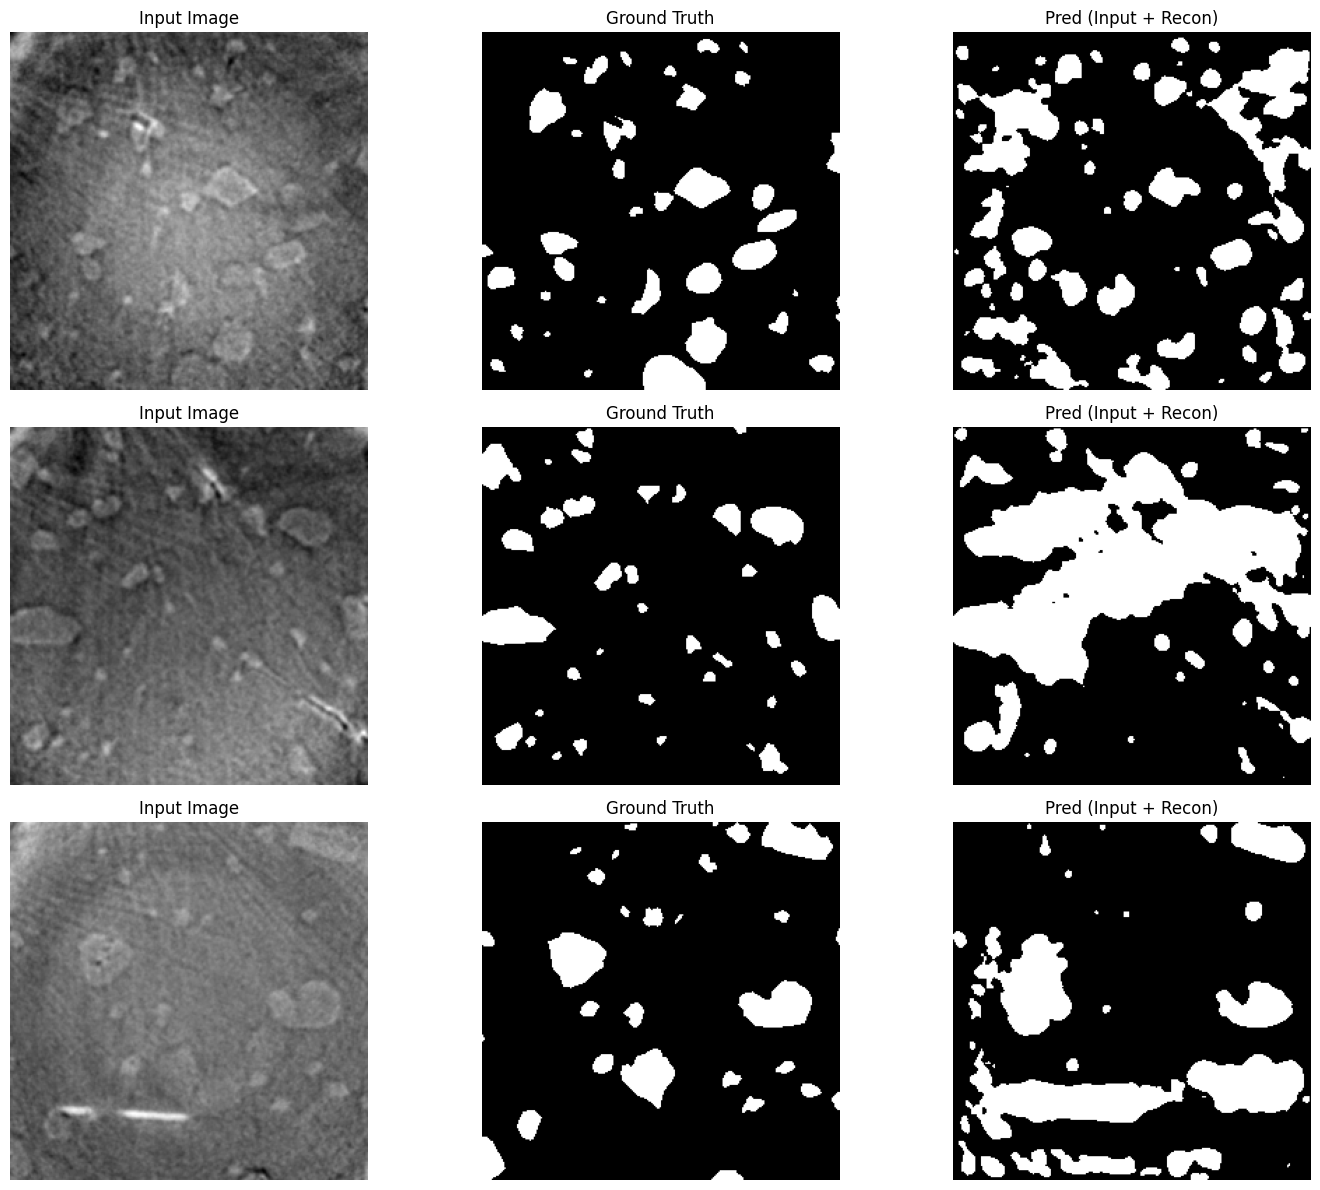

In [27]:
# 1. SETUP
model_input_recon.eval()

# 2. TEST SET EVALUATION
print("\nStarting evaluation of Input+Recon Model...")

total_dice = 0
total_jaccard = 0

with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        y_pred_logits = model_input_recon(X_batch)
        y_pred_binary = (torch.sigmoid(y_pred_logits) > 0.5).float()

        # Metrics
        _, _, _, d, j = calculate_all_metrics_batch(y_pred_binary, y_true)
        total_dice += d
        total_jaccard += j

# AVERAGES
num_batches = len(test_loader)
avg_dice = total_dice / num_batches
avg_jaccard = total_jaccard / num_batches

print(f"Test Set Results (Input + Reconstruction)")
print(f"Dice Coefficient:      {avg_dice:.4f}")
print(f"Jaccard Index (IoU):   {avg_jaccard:.4f}")

# 3. VISUALIZATION
print("\nVisualizing Results...")
X_test_viz, y_test_viz = next(iter(test_loader))
X_test_viz = X_test_viz.to(device)

with torch.no_grad():
    logits = model_input_recon(X_test_viz)
    preds = (torch.sigmoid(logits) > 0.5).float()

X_cpu = X_test_viz.cpu()
y_cpu = y_test_viz.cpu()
p_cpu = preds.cpu()

n = min(3, len(X_cpu))
plt.figure(figsize=(15, 4*n))
for i in range(n):
    # Original
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(X_cpu[i].squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Ground Truth
    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(y_cpu[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # Prediction
    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(p_cpu[i].squeeze(), cmap='gray')
    plt.title("Pred (Input + Recon)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt

# Re-defining the building block for completeness
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class BottleneckFusionUNet(nn.Module):
    def __init__(self, ae_model, latent_dim=128):
        super(BottleneckFusionUNet, self).__init__()

        # 1. Frozen AE
        self.ae = ae_model
        for param in self.ae.parameters():
            param.requires_grad = False

        # ENCODER (Standard U-Net)
        self.enc1 = DoubleConv(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # BOTTLENECK
        # Standard bottleneck goes 512 -> 1024
        self.bottleneck_conv = DoubleConv(512, 1024)

        # FUSION LAYER
        # Takes (Bottleneck 1024 + Latent 128) -> Returns 1024
        self.fusion_layer = nn.Sequential(
            nn.Conv2d(1024 + latent_dim, 1024, kernel_size=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )

        # DECODER (Standard U-Net)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # A. Get Latent z from AE (No Grad)
        with torch.no_grad():
            outputs = self.ae(x)
            z = outputs['z'] # [Batch, 128]

        # B. Encoder Path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # C. Bottleneck
        b = self.bottleneck_conv(self.pool4(e4))
        # b shape is [Batch, 1024, 16, 16] assuming 256x256 input

        # D. FUSION: Expand z and Concatenate
        batch_size, _, h, w = b.shape
        z_expanded = z.view(batch_size, -1, 1, 1).expand(batch_size, -1, h, w)

        # Concatenate along channel dim: 1024 + 128
        b_fused = torch.cat([b, z_expanded], dim=1)

        # Compress back to 1024 channels so the decoder accepts it
        b_fused = self.fusion_layer(b_fused)

        # E. Decoder Path
        d4 = self.upconv4(b_fused)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        out = self.output_conv(d1)
        return out

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fusion = BottleneckFusionUNet(AE, latent_dim=128).to(device)
print("Initialized Bottleneck Fusion Model")

Initialized Bottleneck Fusion Model


Starting training (Bottleneck Fusion)...
* Epoch 01/20 (Time: 1.25s)
  - Train Loss: 0.7563
  - Val Loss:   0.8185
* Epoch 02/20 (Time: 1.20s)
  - Train Loss: 0.6909
  - Val Loss:   0.8216
* Epoch 03/20 (Time: 1.26s)
  - Train Loss: 0.6396
  - Val Loss:   0.8352
* Epoch 04/20 (Time: 1.26s)
  - Train Loss: 0.6278
  - Val Loss:   0.8673
* Epoch 05/20 (Time: 1.23s)
  - Train Loss: 0.5845
  - Val Loss:   0.8611
* Epoch 06/20 (Time: 1.19s)
  - Train Loss: 0.5587
  - Val Loss:   0.8595
* Epoch 07/20 (Time: 1.19s)
  - Train Loss: 0.5293
  - Val Loss:   0.8619
* Epoch 08/20 (Time: 1.19s)
  - Train Loss: 0.5451
  - Val Loss:   0.8652
* Epoch 09/20 (Time: 1.20s)
  - Train Loss: 0.5090
  - Val Loss:   0.8478
* Epoch 10/20 (Time: 1.18s)
  - Train Loss: 0.5134
  - Val Loss:   0.8542
* Epoch 11/20 (Time: 1.21s)
  - Train Loss: 0.4938
  - Val Loss:   0.8075
* Epoch 12/20 (Time: 1.22s)
  - Train Loss: 0.5020
  - Val Loss:   0.7479
* Epoch 13/20 (Time: 1.22s)
  - Train Loss: 0.4679
  - Val Loss:   0.70

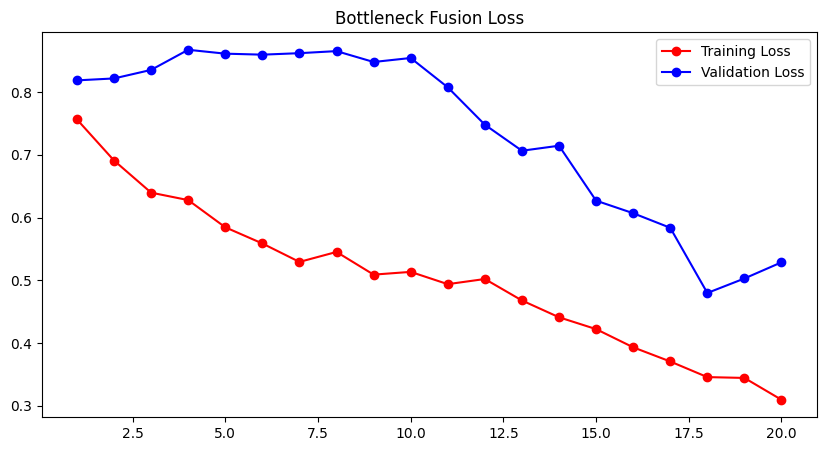

In [29]:
# Configuration
optimizer = optim.Adam(model_fusion.parameters(), lr=1e-3)
loss_fn = DiceLoss()

epochs = 20
train_losses = []
val_losses = []

print("Starting training (Bottleneck Fusion)...")

for epoch in range(epochs):
    tic = time.time()

    # Training Phase
    model_fusion.train()
    model_fusion.ae.eval() # Ensure AE stays frozen

    avg_loss = 0
    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        optimizer.zero_grad()
        y_pred_logits = model_fusion(X_batch)

        loss = loss_fn(y_pred_logits, y_true)
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)

    # Validation Phase
    model_fusion.eval()
    avg_val_loss = 0
    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)

            y_pred_logits = model_fusion(X_batch)
            val_loss = loss_fn(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader)

    toc = time.time()
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

    print(f'* Epoch {epoch+1:02d}/{epochs} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Val Loss:   {avg_val_loss:.4f}')

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, 'r-o', label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, 'b-o', label='Validation Loss')
plt.title('Bottleneck Fusion Loss')
plt.legend()
plt.show()


Visualizing Prediction...


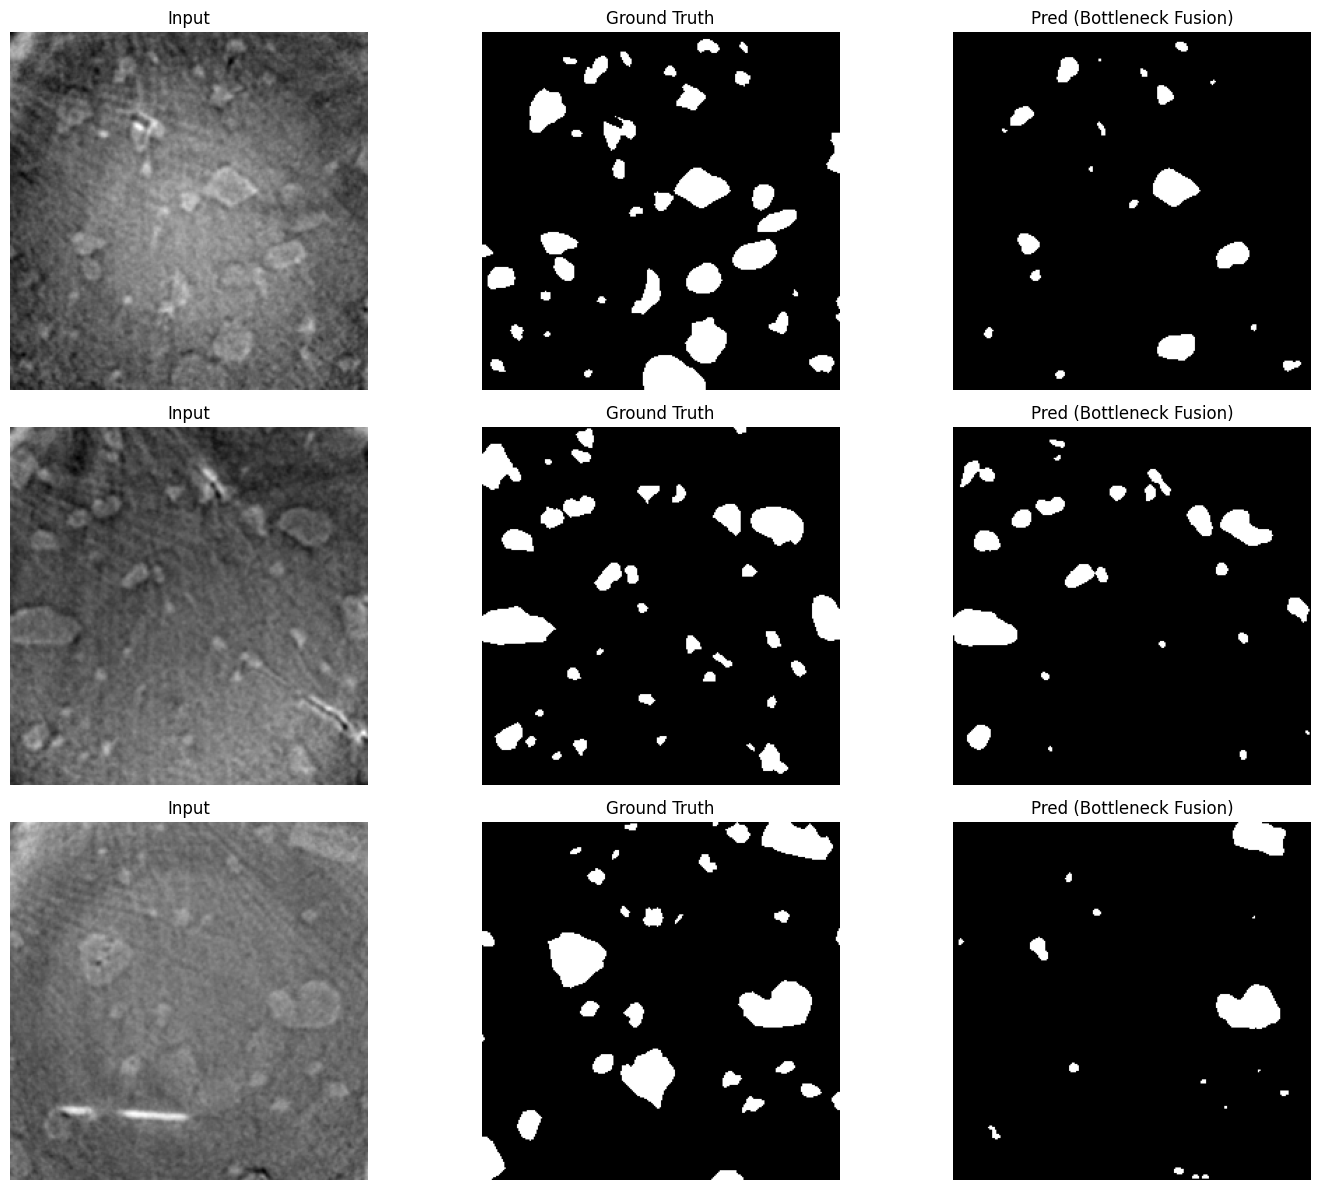


Starting Quantitative Evaluation...
------------------------------
FINAL TEST RESULTS (Bottleneck Fusion)
------------------------------
Dice Score:      0.5351
Jaccard (IoU):   0.3652
Recall:          0.3753
Precision:       0.9316
Pixel Accuracy:  0.9313
------------------------------


In [30]:
print("\nVisualizing Prediction...")
model_fusion.eval()
X_test_viz, y_test_viz = next(iter(test_loader))
X_test_viz = X_test_viz.to(device)

with torch.no_grad():
    logits = model_fusion(X_test_viz)
    preds = (torch.sigmoid(logits) > 0.5).float()

X_cpu = X_test_viz.cpu()
y_cpu = y_test_viz.cpu()
p_cpu = preds.cpu()

n = min(3, len(X_cpu))
plt.figure(figsize=(15, 4*n))
for i in range(n):
    # Input
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(X_cpu[i].squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    # Ground Truth
    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(y_cpu[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # Prediction
    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(p_cpu[i].squeeze(), cmap='gray')
    plt.title("Pred (Bottleneck Fusion)")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 1. SETUP
model_fusion.eval()

# 2. METRIC FUNCTION (Pixel-wise)
def calculate_metrics(preds, y_true, smooth=1e-6):
    preds = preds.contiguous().view(-1).float()
    y_true = y_true.contiguous().view(-1).float()

    tp = (preds * y_true).sum()
    fp = (preds * (1 - y_true)).sum()
    fn = ((1 - preds) * y_true).sum()
    tn = ((1 - preds) * (1 - y_true)).sum()

    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    dice = (2.0 * tp + smooth) / (tp + fp + tp + fn + smooth)
    jaccard = (tp + smooth) / (tp + fp + fn + smooth)
    accuracy = (tp + tn) / (preds.numel())

    return precision.item(), recall.item(), accuracy.item(), dice.item(), jaccard.item()

# 3. TEST LOOP
print("\nStarting Quantitative Evaluation...")

total_dice = 0
total_jaccard = 0
total_recall = 0
total_precision = 0
total_acc = 0
num_batches = 0

with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # Forward Pass
        logits = model_fusion(X_batch)
        preds = (torch.sigmoid(logits) > 0.5).float()

        # Metrics per batch
        p, r, acc, d, j = calculate_metrics(preds, y_true)

        total_precision += p
        total_recall += r
        total_acc += acc
        total_dice += d
        total_jaccard += j
        num_batches += 1

# 4. FINAL RESULTS
print("-" * 30)
print(f"FINAL TEST RESULTS (Bottleneck Fusion)")
print("-" * 30)
print(f"Dice Score:      {total_dice / num_batches:.4f}")
print(f"Jaccard (IoU):   {total_jaccard / num_batches:.4f}")
print(f"Recall:          {total_recall / num_batches:.4f}")
print(f"Precision:       {total_precision / num_batches:.4f}")
print(f"Pixel Accuracy:  {total_acc / num_batches:.4f}")
print("-" * 30)